In [1]:
import sys
sys.path.append('../')

from miquants_demo.data_collection.PriceLoader import load_stock_data,load_index_data
from miquants_demo.optimization.risk_parity import Hierarchical_risk_parity
from miquants_demo.data_collection.UniverseLoader import get_vn30_list
from miquants_demo.utils.metrics import calc_performance_metrics_subset,calc_sharpe_by_year


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from empyrical import stats
import seaborn as sns
import datetime

## Hierarchical risk parity

In [2]:
help(Hierarchical_risk_parity)

Help on class Hierarchical_risk_parity in module miquants_demo.optimization.risk_parity:

class Hierarchical_risk_parity(builtins.object)
 |  Hierarchical_risk_parity(srs, stock_list)
 |  
 |  Methods defined here:
 |  
 |  __init__(self, srs, stock_list)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  get_weight(self)
 |  
 |  plot_dendrogram(self)
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)



In [3]:
vn30 = get_vn30_list()

In [4]:
start_date = '2018-01-01'
end_date = '2023-01-01'
prices = pd.DataFrame()
for name in vn30:
    stock = load_stock_data(name,start_date,end_date)
    prices[name] =stock.close

In [5]:
def split_time_series_for_backtesting(time_series, backtest_period_length):
    """
    Splits a time series into smaller ones for backtesting.

    Args:
        time_series (pd.DataFrame): The input time series to split, with the date index and one or more columns of data.
        backtest_period_length (str): The length of each backtesting period, specified as a string that can be parsed by the pandas frequency string format.

    Returns:
        A list of smaller time series for backtesting, each represented as a pandas DataFrame.
    """
    time_series = time_series.copy()  # Make a copy of the input time series to avoid modifying the original data.
#     time_series.sort_index(inplace=True)  # Sort the time series by date in ascending order.

    start_date = pd.Timestamp(time_series.index.min()) # Set the start date to the earliest date in the time series.
    end_date = start_date + pd.tseries.frequencies.to_offset(backtest_period_length)# Calculate the end date for the first backtesting period.

    backtesting_periods = []  # Initialize an empty list to store the smaller time series for backtesting.

    while end_date <= time_series.index.max()+datetime.timedelta(days=1):
        backtesting_period = time_series.loc[start_date:end_date].copy()  # Extract the current backtesting period.
        backtesting_periods.append(backtesting_period)  # Add the backtesting period to the list.

        start_date = start_date + pd.tseries.frequencies.to_offset(backtest_period_length)+datetime.timedelta(days=1)  # Move the start date forward.
        end_date = end_date + pd.tseries.frequencies.to_offset(backtest_period_length)  # Move the end date forward.

    return backtesting_periods

In [6]:
dataset = prices.pct_change().dropna()
dataset.index = pd.to_datetime(dataset.index)

In [7]:
dataset= dataset['2018':]
dataset

,ACB,BCM,BID,BVH,CTG,FPT,GAS,GVR,HDB,HPG,...,TCB,TPB,VCB,VHM,VIB,VIC,VJC,VNM,VPB,VRE
tradingDate,,,,,,,,,,,,,,,,,,,,,
2018-06-05,-0.007158,0.057971,-0.003268,0.000000,0.016123,0.011642,0.069338,-0.025316,0.004661,-0.016660,...,-0.062496,-0.003367,-0.011803,0.000845,0.027778,0.009166,0.015858,0.020196,0.004084,-0.006583
2018-06-06,0.038380,-0.063927,0.046035,0.002113,0.019362,0.014628,0.042554,-0.012987,0.000000,0.030496,...,-0.041660,-0.017033,0.008538,0.016950,-0.013514,0.024776,0.009245,-0.011295,0.000973,0.000000
2018-06-07,-0.020760,-0.058537,-0.018849,0.008412,-0.020754,-0.014417,-0.032068,0.000000,0.032416,0.018085,...,0.069560,0.000000,-0.006777,0.000000,0.027397,0.000812,0.025197,0.013142,0.000972,-0.006626
2018-06-08,0.016473,-0.020725,0.009584,0.000000,0.007049,0.003119,-0.021091,0.000000,-0.026964,-0.009689,...,0.069092,-0.008628,0.017047,0.000000,-0.013333,0.000000,0.000000,-0.001695,0.046510,-0.011099
2018-06-11,-0.011556,0.042328,-0.015864,0.000000,-0.017475,-0.009371,-0.003078,0.000000,-0.034546,-0.011415,...,0.036135,-0.005236,-0.011724,0.000000,0.013514,0.000800,0.027938,0.017515,0.026986,0.013491
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,-0.034934,-0.022556,-0.005128,-0.050104,-0.057866,-0.020513,0.010837,-0.069686,-0.044118,-0.068120,...,-0.068841,-0.045455,-0.002528,-0.056225,-0.066160,-0.039927,-0.023318,-0.002625,-0.062670,-0.048450
2022-12-27,0.000000,0.024359,0.030928,0.021978,0.021113,0.001309,0.004873,0.067416,0.006154,0.067251,...,0.023346,0.002381,0.002535,0.010638,0.035423,0.009452,-0.008264,0.007895,0.040698,0.050916
2022-12-28,-0.004525,0.000000,0.047500,0.004301,0.020677,0.002614,-0.000970,-0.003509,-0.009174,-0.002740,...,-0.005703,0.016627,0.011378,0.004211,0.000000,0.001873,0.023148,0.005222,0.013966,0.042636


In [8]:
dataset.index = pd.to_datetime(dataset.index)
backtest_period = split_time_series_for_backtesting(dataset,'3M')
len(backtest_period)

18

In [9]:
compare = pd.DataFrame()
train_period =4
test_period=1


index = load_index_data('VNINDEX',str(dataset.index[0].strftime('%Y-%m-%d')),str(dataset.index[-1].strftime('%Y-%m-%d')))
index['VNINDEX'] = index['close'].pct_change()
index = index['VNINDEX']
index.dropna(inplace=True)
index.index = pd.to_datetime(index.index)

for i in range(len(backtest_period)):
    end_idx = len(backtest_period)
    
    ## train data set
    if train_period>1:
        train = pd.concat(backtest_period[i:i+train_period])
    else:
        train = backtest_period[i]
        
    ## test data set
    test_idx_start=i+train_period
    test_idx_end = i+train_period+test_period
    if test_period>1:
        test = pd.concat(backtest_period[test_idx_start:test_idx_end])
    else:
        test = backtest_period[test_idx_start]
    print('train:',train.shape,'from',train.index[0],'to',train.index[-1])
    print('test:',test.shape,'from',test.index[0],'to',test.index[-1])
        
    model = Hierarchical_risk_parity(train,stock_list=vn30)
    weight = model.get_weight()
    rets = weight*test
    rets = np.sum(rets,axis=1)
    rets=pd.DataFrame({'strategy':rets})
    index_rets = index[rets.index[0]:rets.index[-1]]
    iterate_result = pd.concat([rets,index_rets],axis=1)
    compare = pd.concat([compare,iterate_result])
    if test_idx_end ==end_idx:
        print('end')
        break  

train: (247, 30) from 2018-06-05 00:00:00 to 2019-05-31 00:00:00
test: (65, 30) from 2019-06-03 00:00:00 to 2019-08-30 00:00:00
train: (248, 30) from 2018-09-04 00:00:00 to 2019-08-30 00:00:00
test: (64, 30) from 2019-09-03 00:00:00 to 2019-11-29 00:00:00


../miquants_demo/optimization/risk_parity.py:84: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = linkage(d_corr, 'single')
../miquants_demo/optimization/risk_parity.py:84: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = linkage(d_corr, 'single')


train: (248, 30) from 2018-12-03 00:00:00 to 2019-11-29 00:00:00
test: (59, 30) from 2019-12-02 00:00:00 to 2020-02-28 00:00:00
train: (250, 30) from 2019-03-01 00:00:00 to 2020-02-28 00:00:00
test: (62, 30) from 2020-03-02 00:00:00 to 2020-05-29 00:00:00


../miquants_demo/optimization/risk_parity.py:84: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = linkage(d_corr, 'single')
../miquants_demo/optimization/risk_parity.py:84: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = linkage(d_corr, 'single')


train: (250, 30) from 2019-06-03 00:00:00 to 2020-05-29 00:00:00
test: (66, 30) from 2020-06-01 00:00:00 to 2020-08-31 00:00:00
train: (251, 30) from 2019-09-03 00:00:00 to 2020-08-31 00:00:00
test: (64, 30) from 2020-09-01 00:00:00 to 2020-11-30 00:00:00


../miquants_demo/optimization/risk_parity.py:84: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = linkage(d_corr, 'single')
../miquants_demo/optimization/risk_parity.py:84: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = linkage(d_corr, 'single')


train: (251, 30) from 2019-12-02 00:00:00 to 2020-11-30 00:00:00
test: (53, 30) from 2020-12-01 00:00:00 to 2021-02-26 00:00:00
train: (245, 30) from 2020-03-02 00:00:00 to 2021-02-26 00:00:00
test: (63, 30) from 2021-03-01 00:00:00 to 2021-05-31 00:00:00


../miquants_demo/optimization/risk_parity.py:84: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = linkage(d_corr, 'single')
../miquants_demo/optimization/risk_parity.py:84: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = linkage(d_corr, 'single')


train: (246, 30) from 2020-06-01 00:00:00 to 2021-05-31 00:00:00
test: (66, 30) from 2021-06-01 00:00:00 to 2021-08-31 00:00:00
train: (246, 30) from 2020-09-01 00:00:00 to 2021-08-31 00:00:00
test: (63, 30) from 2021-09-01 00:00:00 to 2021-11-30 00:00:00


../miquants_demo/optimization/risk_parity.py:84: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = linkage(d_corr, 'single')
../miquants_demo/optimization/risk_parity.py:84: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = linkage(d_corr, 'single')


train: (245, 30) from 2020-12-01 00:00:00 to 2021-11-30 00:00:00
test: (58, 30) from 2021-12-01 00:00:00 to 2022-02-28 00:00:00
train: (250, 30) from 2021-03-01 00:00:00 to 2022-02-28 00:00:00
test: (63, 30) from 2022-03-01 00:00:00 to 2022-05-31 00:00:00


../miquants_demo/optimization/risk_parity.py:84: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = linkage(d_corr, 'single')
../miquants_demo/optimization/risk_parity.py:84: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = linkage(d_corr, 'single')


train: (250, 30) from 2021-06-01 00:00:00 to 2022-05-31 00:00:00
test: (66, 30) from 2022-06-01 00:00:00 to 2022-08-31 00:00:00
train: (250, 30) from 2021-09-01 00:00:00 to 2022-08-31 00:00:00
test: (63, 30) from 2022-09-05 00:00:00 to 2022-11-30 00:00:00
end


../miquants_demo/optimization/risk_parity.py:84: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = linkage(d_corr, 'single')
../miquants_demo/optimization/risk_parity.py:84: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = linkage(d_corr, 'single')


In [27]:
compare.dropna(inplace=True)

In [28]:
equal_weight = (1/len(vn30))*dataset
equal_weight = np.sum(equal_weight,axis=1)
equal_weight = equal_weight[compare.index[0]:]
equal_weight.index= pd.to_datetime(equal_weight.index)
equal_weight

tradingDate
2019-06-03   -0.014355
2019-06-04    0.004050
2019-06-05    0.000917
2019-06-06   -0.001923
2019-06-07    0.013449
                ...   
2022-12-26   -0.043565
2022-12-27    0.022393
2022-12-28    0.010458
2022-12-29   -0.008298
2022-12-30   -0.002985
Length: 897, dtype: float64

In [29]:
compare.index = pd.to_datetime(compare.index)
compare['equal weight'] = equal_weight
compare

,strategy,VNINDEX,equal weight
tradingDate,,,
2019-06-03,-0.010199,-0.013970,-0.014355
2019-06-04,0.003236,0.004955,0.004050
2019-06-05,0.002967,0.000263,0.000917
2019-06-06,-0.001741,-0.003363,-0.001923
2019-06-07,0.010748,0.010620,0.013449
...,...,...,...
2022-11-24,-0.001080,0.001808,0.001702
2022-11-25,0.014778,0.025060,0.021136
2022-11-28,0.022525,0.035236,0.032764


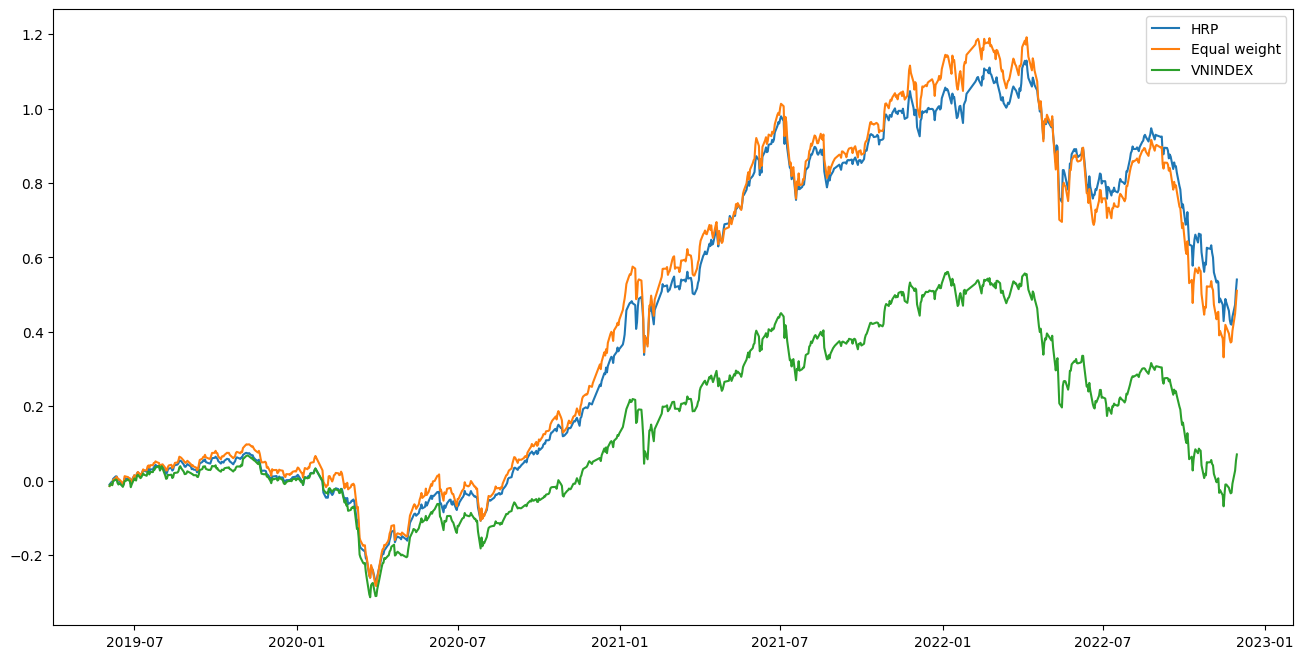

In [30]:
fig, ax = plt.subplots(1,1,figsize=(16,8))

ax.plot(stats.cum_returns(compare.strategy),label='HRP')
ax.plot(stats.cum_returns(compare['equal weight']),label='Equal weight')
ax.plot(stats.cum_returns(compare.VNINDEX),label='VNINDEX')
plt.legend()
plt.show()

In [31]:
xxx = calc_performance_metrics_subset(compare)
metrics = pd.DataFrame({'Annual return':xxx['annual_return'],'Annual volatility':xxx['annual_volatility'],'Downside risk':xxx['downside_risk'],'Max drawdown':xxx['max_drawdown'].to_list()})
metrics = metrics.applymap("{0:.2%}".format)
metrics.T

,strategy,VNINDEX,equal weight
Annual return,13.25%,1.98%,12.61%
Annual volatility,19.22%,21.20%,22.84%
Downside risk,14.41%,16.44%,17.33%
Max drawdown,33.32%,40.34%,39.24%


In [32]:
x1 = calc_sharpe_by_year(compare[['strategy']].rename(columns={'strategy':'captured_returns'}))
x2 = calc_sharpe_by_year(compare[['equal weight']].rename(columns={'equal weight':'captured_returns'}))
x3 = calc_sharpe_by_year(compare[['VNINDEX']].rename(columns={'VNINDEX':'captured_returns'}))

sharpe_df = pd.DataFrame({'HRP':x1,'Equal':x2,'Vnindex':x3})
sharpe_df[:-1]

,HRP,Equal,Vnindex
sharpe_ratio_2019,0.241665,0.468158,0.067669
sharpe_ratio_2020,1.534513,1.487035,0.642331
sharpe_ratio_2021,2.174956,1.847302,1.567952


In [34]:
import scipy
ts1 = compare['strategy']
ts2 =compare['equal weight']
ts3 = compare['VNINDEX']

statistics1 = scipy.stats.describe(ts1)
statistics2 = scipy.stats.describe(ts2)
statistics3 = scipy.stats.describe(ts3)

moment_compare = pd.DataFrame(index=['mean','std','skewness','kurtosis'],columns=['HRP','Equal','Vnindex'])
moment_compare.loc['mean',:]=round(statistics1.mean,4),round(statistics2.mean,4),round(statistics3.mean,4)
moment_compare.loc['std',:]=round(np.sqrt(statistics1.variance),4),round(np.sqrt(statistics2.variance),4),round(np.sqrt(statistics3.variance),4)
moment_compare.loc['skewness',:]=round(statistics1.skewness,4),round(statistics2.skewness,4),round(statistics3.skewness,4)
moment_compare.loc['kurtosis',:]=round(statistics1.kurtosis,4),round(statistics2.kurtosis,4),round(statistics3.kurtosis,4)
moment_compare

,HRP,Equal,Vnindex
mean,0.0006,0.0006,0.0002
std,0.0121,0.0144,0.0134
skewness,-0.8937,-0.9127,-0.9764
kurtosis,4.1251,3.6972,3.99


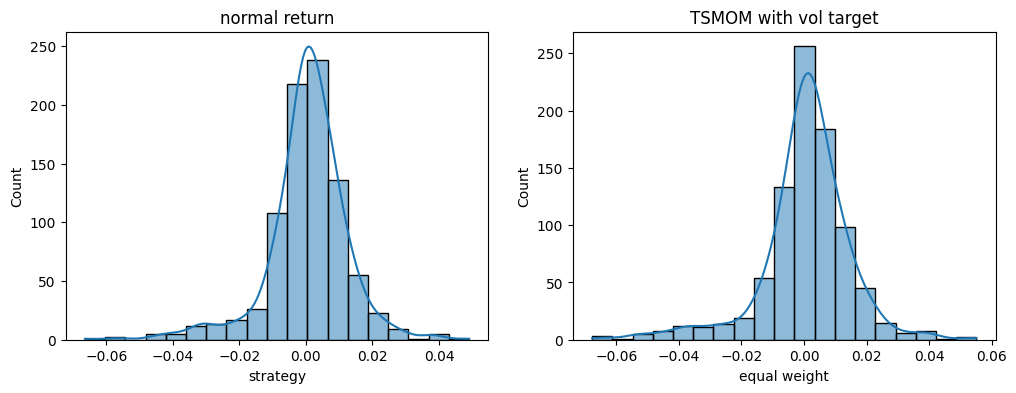

In [35]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,4))
bins = 19
sns.histplot(ts1,bins=bins,kde=True,ax=ax1)
ax1.title.set_text('normal return')

sns.histplot(ts2,bins=bins,kde=True,ax=ax2)
ax2.title.set_text('TSMOM with vol target')



plt.show()